## Image Captioning

### Steps
1. Data Collection
2. Understanding the data
3. Data Cleaning
4. Loading the training set
5. Data Preprocessing of Images
6. Data Preprocessing of Captions
7. Data Preparation using Generator Function
8. Word Embeddings
9. Model Architecture
10. Inference
11. Evaluation

## Flikr8k Dataset
- 6000 images for training
- 1000 for validation
- 1000 for testing

- 5 captions to describe an image

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

### Read the captions from the file

In [2]:
def readTextFile(path):
    
    with open(path) as f:
        
        # We are used read() because readlines() will give a separate lines to a big caption
        captions = f.read()
        
    return captions

In [3]:
captions = readTextFile("../input/flikr8k/Flickr8k_text/Flickr8k.token.txt")
# print(captions)
# Data is large

In [4]:
captions = captions.split("\n")[:-1]
len(captions) # total lines

40460

In [5]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

### Dictionary to map each image to its corresponding caption

In [6]:
# Image_Id : [ list of captions ]

descriptions = {}

for x in captions:
    
    first, second = x.split("\t")
    img_name = first.split('.')[0]
    
    # if img_name doesn't exist
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(second)

In [7]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

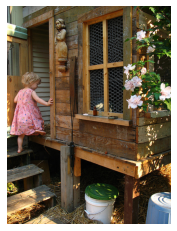

In [8]:
## Image
sample = image.load_img("../input/flikr8k/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg")
plt.imshow(sample)
plt.axis("off")
plt.show()

## Data Cleaning
- don't remove stopwords : the model should know how to insert stopwords in a sentence
- don't perform stemming : for proper English
- remove non-alphabetical symbols : reduces vocab size

In [9]:
def clean_text(sentence):
    
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " ", sentence) # Removing all the non-alphabetical characters/words
    sentence = sentence.split()
    
    sentence = [w for w in sentence if len(w)>1 ]
    
    sentence = " ".join(sentence)
    
    return sentence
    

In [10]:
clean_text("A Cat is sitting over the house #64")

'cat is sitting over the house'

In [11]:
# Clean all the captions
for key,caption_list in descriptions.items():
    
    for i in range(len(caption_list)):
        
        caption_list[i] = clean_text(caption_list[i])

In [12]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
# Storing these descriptions in a text file
with open("descriptions.txt", "w") as f:
    f.write(str(descriptions))

### Creating Vocabulary
- model gives an output in the form of a vector
- we need to convert that vector into a specific word
- therefore, we need a vocab

In [14]:
descriptions = None
# Directly reading the preprocessed file
with open("descriptions.txt","r") as f:
    descriptions = f.read()
    
json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [15]:
print(type(json_acceptable_string)) # Which we read from the file
print(type(descriptions)) # which we converted into a dict using json.loads()

<class 'str'>
<class 'dict'>


In [16]:
# Vocab

vocab = set()

for key in descriptions.keys():
    
    [vocab.update(sentence.split()) for sentence in descriptions[key] ]

print("Size of Vocab :", len(vocab))


Size of Vocab : 8424


In [17]:
# Total number of words across all the sentences

total_words = []

for key in descriptions.keys():
    
    [total_words.append(i) for des in descriptions[key] for i in des.split() ]
    
print("Total Words : ", len(total_words))

Total Words :  373837


In [18]:
# Filter words from the vocab according to ceratin threshold frequency
import collections

# word : freq
counter = collections.Counter(total_words)

# as a dict
freq_count = dict(counter)

print(freq_count)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [19]:
# Sorting the dict according to freq count

# x[0] : key || x[1] : value
sorted_freq_count = sorted( freq_count.items(), reverse=True, key=lambda x : x[1])

# Filtering according to threshold
threshold = 10
sorted_freq_count = [ x for x in sorted_freq_count if x[1] > threshold]
total_words = [ x[0] for x in sorted_freq_count ]

In [20]:
len(total_words)

1845

### Final Vocab Size : 1845 !!
- total words : 3,73,837
- unique words : 8,424
- filtered vocab : 1,845

## Prepare Train and Test Data
The motive is to create :
- train_description
- test_description
- These are ( image_name, list of captions )

In [21]:
# These are strings of all the image names
train_file_data = readTextFile("../input/flikr8k/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("../input/flikr8k/Flickr8k_text/Flickr_8k.testImages.txt")

In [22]:
# Splitting the file to retrieve the image names

train = [ row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [ row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [23]:
print(len(train))
print(len(test))

6000
1000


### Note: We will preprocess only the train captions

### Prepare Descriptions for the training data
- We need to add < s > ( start token ) and an < e > ( end token )
- < s > is needed to begin the sent, along with the image vector
- < e > is needed to be generated to end the sentence
- That is why, these special tokens are added so that the model learns when to start and end

In [24]:
train_descriptions = {}

for img_id in train:
    
    train_descriptions[img_id] = []
    
    for caption in descriptions[img_id]:
        
        caption_to_append = "startseq " + caption + " endseq"
        train_descriptions[img_id].append(caption_to_append)
        

In [25]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### TRANSFER LEARNING
- Images --> Features
- Text --> Features

## Image Feature Extraction
- ResNet50 Model
- It has __skip connections__ and branching
- That is why, there is separate column for __"Connected to"__
- Skip Connections helps in tackling with Vanishing Gradients

In [26]:
model = ResNet50(weights="imagenet", input_shape=(224, 224, 3))
model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [27]:
# (m X 2048) : output [ ENCODING ]
# 2048 represents the number of features
model_new = Model(model.input, model.layers[-2].output)

### Extraction of features from images
1. Image is preprocessed
2. Passed to ResNet-50 Conv Base
3. Receives a (m X 2048) tensor [ m : number of examples ]
4. Store these feature vectors

In [28]:
def preprocess_img(img):
    
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    
    # Converted from 3D to a 4D tensor
    # EX: (224, 224, 3) -- axis=0 --> (1, 224, 224, 3)
    # We can also use resape
    img = np.expand_dims(img, axis=0)
    
    # We need to feed this image to the ResNet-50 model
    # Normalizing according to how it was trained
    img = preprocess_input(img)
    
    return img

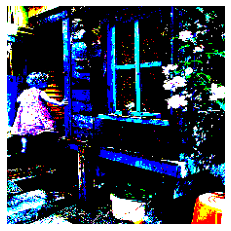

In [29]:
# Sample
sample = preprocess_img("../input/flikr8k/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg")
plt.imshow(sample[0]) # as it is a tensor
plt.axis("off")
plt.show()
# The image seems different due to the Normalization technique used by ResNet-50
# It subtracts the channel mean ( R G and B ) from each corresponding channel

In [30]:
# Encoding an Image
def encode_image(img):
    img = preprocess_img(img)
    # (1 X 2048)
    feature_vector = model_new.predict(img)
    # 2048
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [31]:
encode_image("../input/flikr8k/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg")

array([0.06535938, 0.16782546, 0.32517588, ..., 0.05107139, 0.32821164,
       1.0043377 ], dtype=float32)

In [32]:
# Encoding all Images
start = time()
IMAGE_PATH = "../input/flikr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

# (image_id, feature_vector)
encoding_train = {}

for ix, img_id in enumerate(train):
    img_path = IMAGE_PATH + img_id + ".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    # Tracking the progress
    if ix%100 == 0:
        print("Encoding in progress || Time step {}".format(ix))
        
end = time()
print("Total time {}".format(end - start))

Encoding in progress || Time step 0
Encoding in progress || Time step 100
Encoding in progress || Time step 200
Encoding in progress || Time step 300
Encoding in progress || Time step 400
Encoding in progress || Time step 500
Encoding in progress || Time step 600
Encoding in progress || Time step 700
Encoding in progress || Time step 800
Encoding in progress || Time step 900
Encoding in progress || Time step 1000
Encoding in progress || Time step 1100
Encoding in progress || Time step 1200
Encoding in progress || Time step 1300
Encoding in progress || Time step 1400
Encoding in progress || Time step 1500
Encoding in progress || Time step 1600
Encoding in progress || Time step 1700
Encoding in progress || Time step 1800
Encoding in progress || Time step 1900
Encoding in progress || Time step 2000
Encoding in progress || Time step 2100
Encoding in progress || Time step 2200
Encoding in progress || Time step 2300
Encoding in progress || Time step 2400
Encoding in progress || Time step 250

## Storing the features to the disk
- We will use __PICKLE__
- RAM <=> DISK
- for storing data in disk : __dump__
- for loading data in RAM : __load__


In [33]:
with open("encoded_train_features.pkl", "wb") as f:
    pickle.dump(encoding_train, f)

### Doing the same for extracting Test features

In [34]:
# Encoding all Images
start = time()
IMAGE_PATH = "../input/flikr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

# (image_id, feature_vector)
encoding_test = {}

for ix, img_id in enumerate(test):
    img_path = IMAGE_PATH + img_id + ".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    # Tracking the progress
    if ix%100 == 0:
        print("Encoding in progress || Time step {}".format(ix))
        
end = time()
print("Total time {}".format(end - start))

Encoding in progress || Time step 0
Encoding in progress || Time step 100
Encoding in progress || Time step 200
Encoding in progress || Time step 300
Encoding in progress || Time step 400
Encoding in progress || Time step 500
Encoding in progress || Time step 600
Encoding in progress || Time step 700
Encoding in progress || Time step 800
Encoding in progress || Time step 900
Total time 52.914249897003174


In [35]:
with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)

## Data Preprocessing for Captions

In [36]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    
    # We are not using 0 as it is reserved for extrapolating short sentences
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [37]:
# Adding <s> and <e>
print(len(idx_to_word))

1845


In [38]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1 # 1 for 0 that is reserved
print("Vocab Size : {}".format(vocab_size))

Vocab Size : 1848


In [39]:
max_len = 0 # for training batches to the model
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))
        
print(max_len)

35


## Creating a Data Loader/Generator

In [40]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    X1, X2, y = [],[],[]
    
    n = 0
    while True:
        
        # for image_id, caption_list in train_descriptions
        for key, desc_list in train_descriptions.items():
            n += 1
            
            # (2048,) vector of the image
            photo = encoding_train[key]
            
            # for caption in caption_list
            for desc in desc_list:
                
                # Each word contributes to a training point
                # If the word is not present in the vocab, then ignore it
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                
                # Setting up as a SUPERVISED LEARNING PROBLEM
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    # Remember, we reserved 0 [ padding word ]
                    # Because, we needed to pad the sentence so as it's length = max_len
                    # It accepts a 2d matrix
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    
                    # one hot encoding
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n == batch_size:
                    # Here we use generator
                    yield ([np.array(X1), np.array(X2)], np.array(y))
                    
                    X1, X2, y = [],[],[]
                    n = 0

## Word Embeddings
- Embedding layer can be trained
- Use a pre-trained Embedding Layer ( TRANSFER LEARNING )
- We will use GLOVE embeddings ( Glove6b50D.txt )

In [41]:
f = open("../input/glove-embeddings/glove.6B.50d.txt", encoding='utf8')

In [42]:
embedding_index = {}

for line in f:
    
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:], dtype='float')
    embedding_index[word] = word_embedding

In [43]:
f.close()

In [44]:
# 50 dimensional glove vector for "apple"
print(embedding_index["apple"])

[ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
 -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
  0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
 -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
  0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
 -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
 -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.30938
  0.26581 ]


### Building Embedding matrix for our Vocab
- If the word is not found in embedding_index, then that word will be a 0 vector

In [45]:
def get_embedding_matrix():
    
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    
    for word,idx in word_to_idx.items():
        
        # 50d vector from GLOVE embeddings
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [46]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


In [47]:
embedding_matrix[1847] # start and end sequence are not in Glove embeddings
# Thus, it will be a 0 vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model Architecture

In [48]:
# Image Model

# ResNet50's output for image
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [49]:
# Captions as Input

input_captions = Input(shape=(max_len,)) #35

# Embeddings (batch_size,35,) --> (batch_size,35,50)
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)

inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2) # 256 : output activation vector/ Hidden vector

In [50]:
# Concatenating Image and Captions
# Combining both of their outputs

# 2 (256,) tensors as input
decoder1 = add([inp_img2, inp_cap3])

# Those 2 tensors are combined to create a (256,) tensor
decoder2 = Dense(256, activation='relu')(decoder1)

outputs = Dense(vocab_size, activation='softmax')(decoder2)


In [51]:
# Combined Model
model = Model(inputs=[input_img_features, input_captions], outputs=outputs)

In [52]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

### __Pre-Initializing Embedding Layer__
- with Glove Vectors matrix, which we have already created

In [53]:
model.layers[2].set_weights([embedding_matrix])
# As we are using a pretrained model,
# Therefore, no need to train the Embedding Layer
model.layers[2].trainable = False

In [54]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Training Of Model

In [55]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

In [56]:
import os
os.mkdir("model_weights")

In [57]:
def train():
    
    for i in range(epochs):
        print(i)
        generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
        # Each batch will be passed for 1 epoch
        model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save('./model_weights/model_' + str(i) + ".h5")

In [58]:
train()

0
2000/2000 [==============================] - 31s 16ms/step - loss: 4.3012
1
2000/2000 [==============================] - 30s 15ms/step - loss: 3.5932
2
2000/2000 [==============================] - 31s 16ms/step - loss: 3.3369
3
2000/2000 [==============================] - 30s 15ms/step - loss: 3.1822
4
2000/2000 [==============================] - 32s 16ms/step - loss: 3.0695
5
2000/2000 [==============================] - 31s 15ms/step - loss: 2.9855
6
2000/2000 [==============================] - 30s 15ms/step - loss: 2.9169
7
2000/2000 [==============================] - 30s 15ms/step - loss: 2.8621
8
2000/2000 [==============================] - 32s 16ms/step - loss: 2.8178
9
2000/2000 [==============================] - 31s 15ms/step - loss: 2.7762
10
2000/2000 [==============================] - 31s 15ms/step - loss: 2.7415
11
2000/2000 [==============================] - 32s 16ms/step - loss: 2.7099
12
2000/2000 [==============================] - 31s 15ms/step - loss: 2.6858
13
2000/2

In [59]:
# Loading the weights
model = load_model("./model_weights/model_29.h5")

## Predictions

In [60]:
def predict_caption(photo):
    
    # We will feed 2 things to the model
    # 1. Feed the image vector (2048,)
    # 2. Provide the start sequence "startseq" (<s>)
    
    inp_text = "startseq"
    
    for i in range(max_len):
        
        sequence = [word_to_idx[w] for w in inp_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        ypred = model.predict([photo,sequence])
        
        # Greedy Sampling : Word with max probability always
        ypred = ypred.argmax()
        
        # retreiving the word
        word = idx_to_word[ypred]
        
        # adding it to the sequence
        inp_text += (' ' + word)
        
        # If <e>/end sequence is encountered
        if word == "endseq":
            break
            
    # removing <s> and <e>
    final_caption = inp_text.split(' ')[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

## Testing
- Testing on some random images

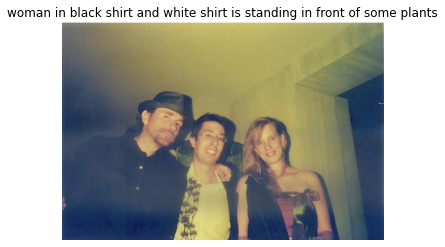

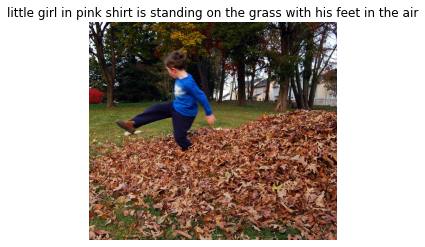

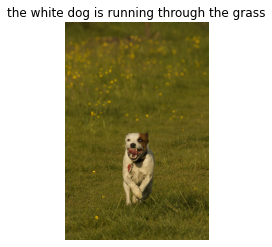

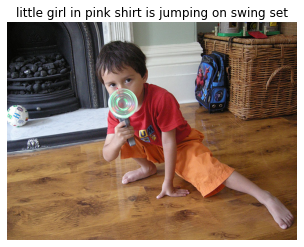

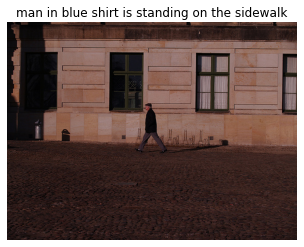

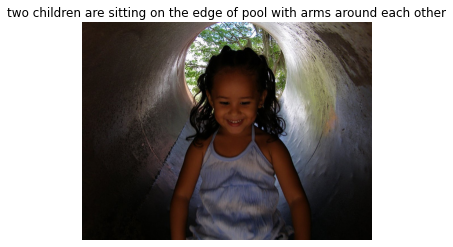

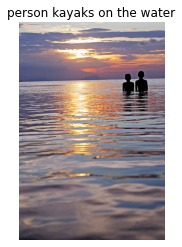

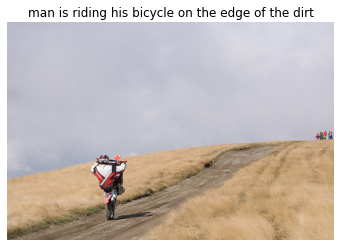

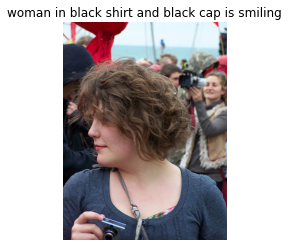

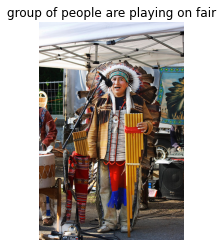

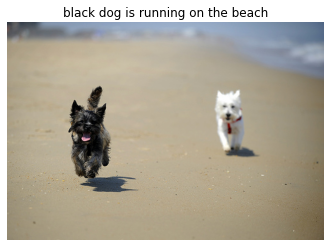

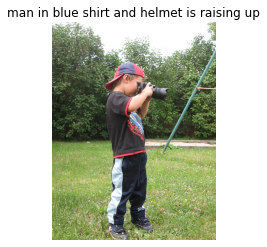

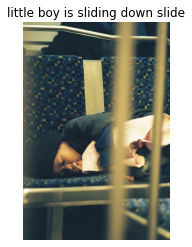

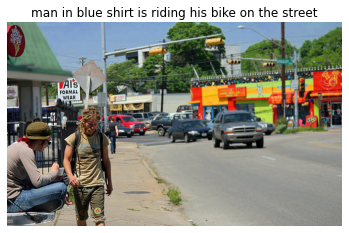

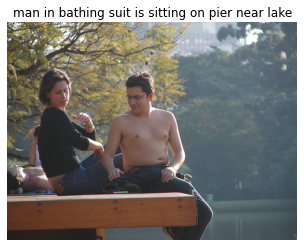

In [61]:
for i in range(15):
    
    # We have 1000 testing images
    idx = np.random.randint(0, 1000)
    
    all_test_images = list(encoding_test.keys())
    
    img_name = all_test_images[idx]
    
    test_photo = encoding_test[img_name].reshape((1, 2048))
    
    i = plt.imread(IMAGE_PATH + img_name + ".jpg")
    
    caption = predict_caption(test_photo)
    plt.imshow(i)
    plt.title(caption)
    plt.axis("off")
    plt.show()
    
    

## Thanks for Reading the Notebook
## ANY IMPROVEMENTS AND SUGGESTIONS ARE WELCOMED
## Have a Nice Day :)